In [1]:
import pm4py
import pandas as pd
import conformance_checker as cc
import process_discovery
import requests
import json
import utilities
from bot_parser import get_bot_parser
import uuid

In [2]:
def getBotInfo(endpoint="http://localhost:8080/SBFManager"):
    """
    Fetches the first bot from the social bot manager and returns its id and name
    """
    response = requests.get(f"{endpoint}/bots")
    if response.status_code == 200:
        data = json.loads(response.content)
        if len(data) == 0:
            return None
        first_value = list(data.values())[0]
        return first_value['id'], first_value['name']
    else:
        return None

In [3]:
bot_manager_endpoint = "http://localhost:8080/SBFManager"

bot_id, bot_name = getBotInfo(bot_manager_endpoint)

event_log_generator_endpoint = "http://localhost:8087"

log = utilities.fetch_event_log(bot_name, event_log_generator_endpoint)
if log is None:
    raise ValueError("Event log not found")

/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching event log from http://localhost:8087/bot/MensaBot


parsing log, completed traces :: 100%|██████████| 5/5 [00:00<00:00, 2796.58it/s]
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.11/site-packages/pm4py/utils.py:499: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


# Discovered Model

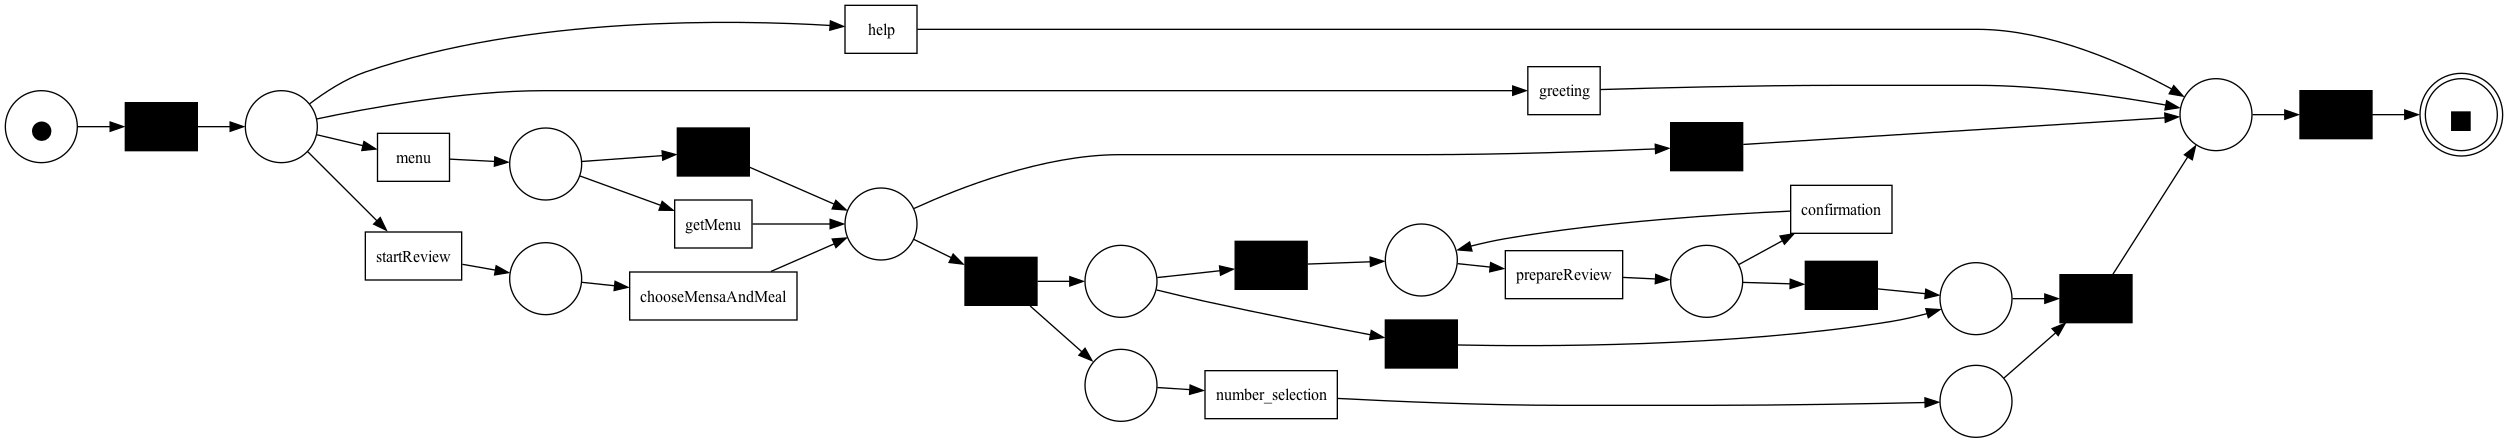

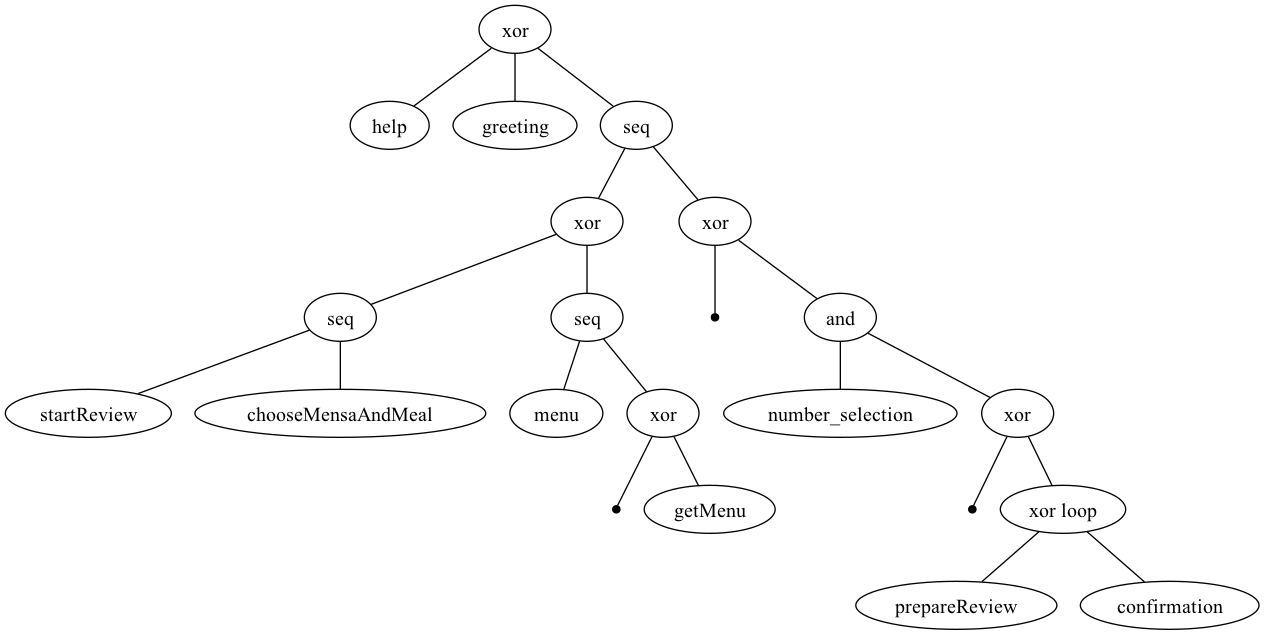

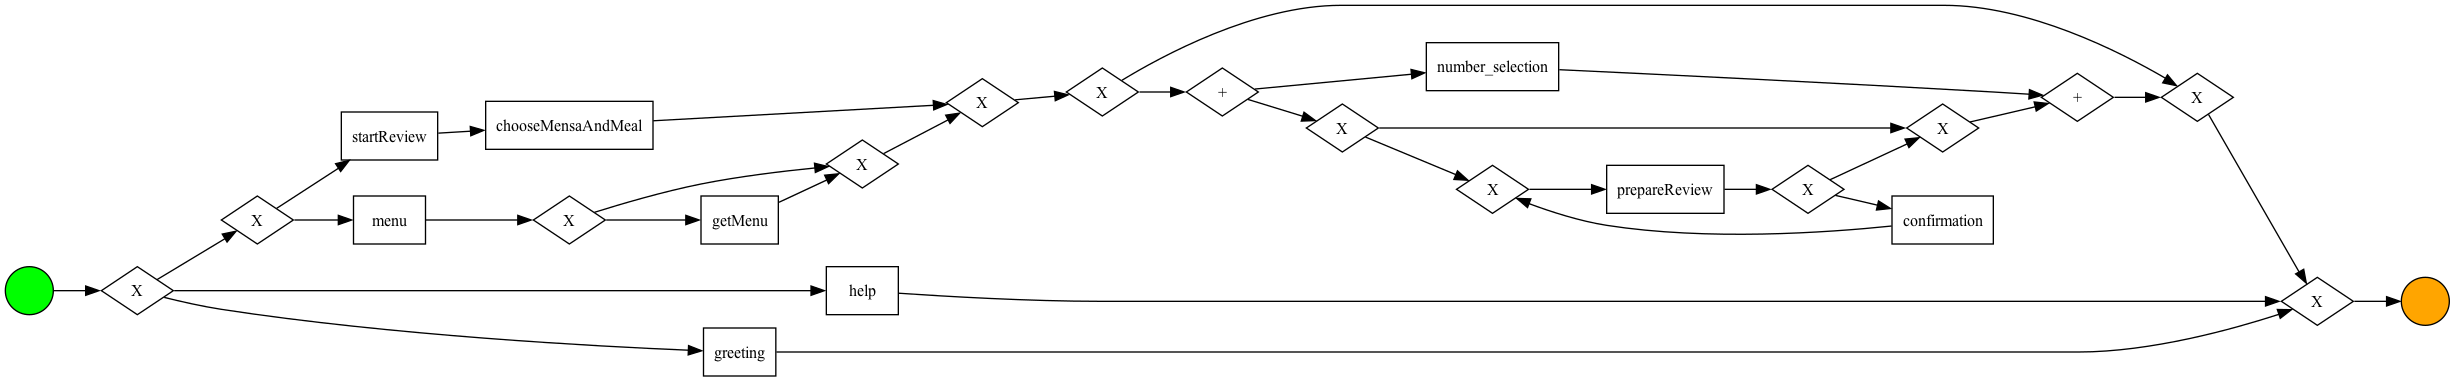

In [4]:
net,im,fm = process_discovery.discover_petri_net(log)
pm4py.view_petri_net(net,im,fm)
process_tree = process_discovery.discover_process_tree(log)
pm4py.view_process_tree(process_tree)
bpmn = process_discovery.discover_bpmn(log)
pm4py.view_bpmn(bpmn)

In [5]:
traces = pm4py.get_variants(log)
traces

{('greeting',): 1,
 ('help',): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 1,
 ('menu', 'getMenu', 'number_selection'): 1,
 ('menu',): 1}

# Bot Model

Fetching bot model from http://localhost:8080/SBFManager/models/MensaBot


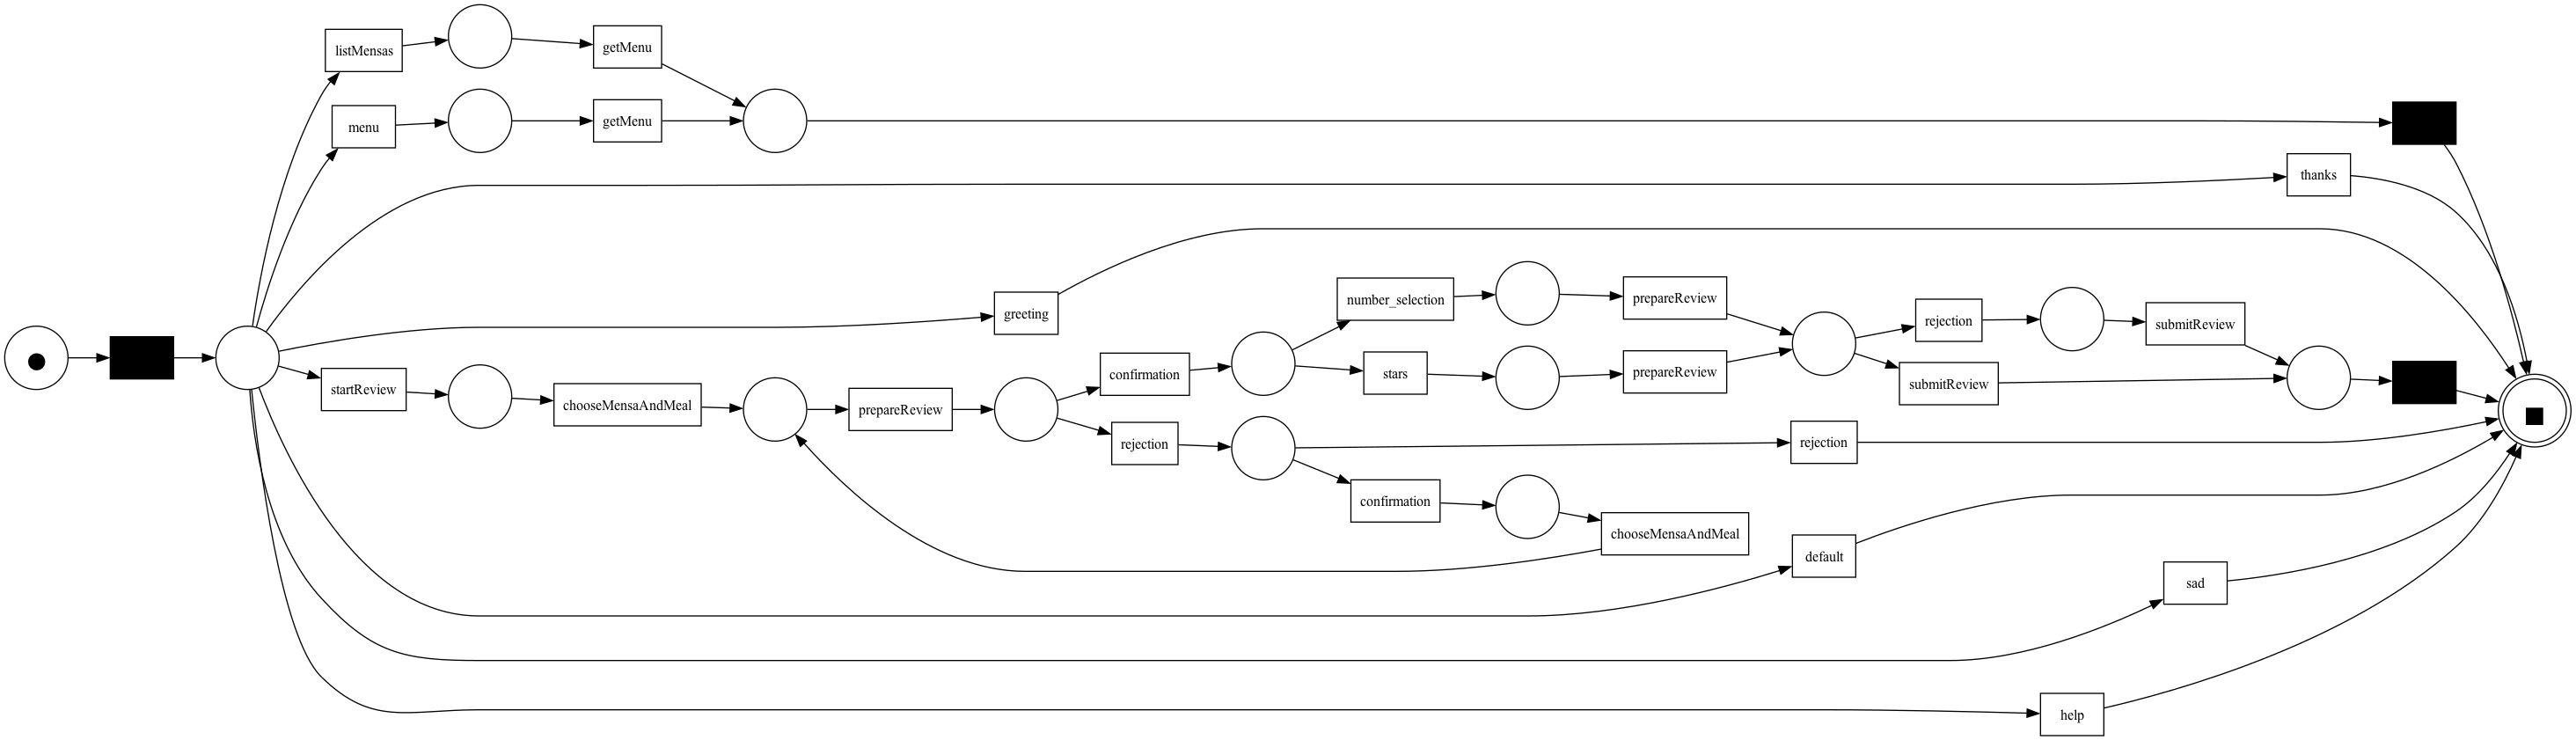

In [6]:
model = utilities.fetch_bot_model(bot_name,bot_manager_endpoint)
bp = get_bot_parser(model)
bot_net,bot_im,bot_fm= bp.to_petri_net()
dfg,start_activities,end_activities = bp.to_dfg()
bot_net=pm4py.reduce_petri_net_invisibles(bot_net)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)


In [7]:
unfitting_traces = cc.find_unfitting_traces(log, bot_net, bot_im, bot_fm)
missing_log_moves = list()
for trace in unfitting_traces:
    for move in trace['alignment']:
        if move[0] == ">>" and move[1]!= None:
            missing_log_moves.append(move[1])

print(f"Missing log moves: {missing_log_moves}")

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 795.07it/s]

Missing log moves: ['submitReview', 'getMenu']


In [9]:
for diagnostic in unfitting_traces:
    prev_activity = None
    aligned_trace = diagnostic['alignment']
    for step in aligned_trace:
        if step[1] ==">>":
            print("Move on log: "+step[0]+"\n")
            # in this case the activity is not present in the bot model, we adjust the dfg to make it fit
            # generate a new id for the activity using uuid
            new_activity_id = str(uuid.uuid4())
            if(prev_activity is not None):
                dfg[prev_activity][new_activity_id] = dfg[prev_activity][step[0]]
                del dfg[prev_activity][step[0]]

        prev_activity = step[0]

Move on log: number_selection



KeyError: 'getMenu'